# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>
---

**Lab 07**: Structured Streaming with Files 

**Date**: October 10th 2025

**Student Name**: Luis Roberto Chavez Mancilla

**Professor**: Pablo Camarillo Ramirez

# Create Spark Session

In [2]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Lab 07 - Structured Streaming") \
    .master("spark://spark-master:7077") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")
# Optimization (reduce the number of shuffle partitions)
spark.conf.set("spark.sql.shuffle.partitions", "5")

### Install netcat utility

In [3]:
!apt-get update
!apt-get install -y netcat

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease  
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [3,425 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:6 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [5,727 kB]
Get:7 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,276 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [3,750 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,584 kB]
Fetched 16.1 MB in 3s (6,052 kB/s)                         
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
netcat is already the newest version (1.218-4ubuntu1).
0 upgraded, 0 newly installed, 0 to remov

### Generate random web logs
En nuestro script que hicimos de producer se generan varios archivo de logs en una carpeta data.

`python .\spark\notebooks\lib\robertoman\producer.py`

### Create schema

In [4]:
from robertoman.spark_utils import SparkUtils

logs_schema = SparkUtils.generate_schema(
    [
        ("timestamp", "string"),
        ("log_type", "string"),
        ("message", "string"),
        ("server", "string"),
    ]
)

Stream

In [ ]:
from pyspark.sql.functions import split, col, to_timestamp, trim

logs_df = (spark.readStream
    .format("text")
    .option("maxFilesPerTrigger", 1) #generar un batch por file >= 3 batches
    .load("/opt/spark/work-dir/data/lab7_roberto"))

# ya que se dividieron por "|" cada elemento hay que usar "\s*\|\s*" para que no considere los espacios del |
parts = split(col("value"), r"\s*\|\s*") # columna
parsed_logs_df = (logs_df.select(
        to_timestamp(parts.getItem(0), "yyyy-MM-dd HH:mm:ss").alias("timestamp"),
        trim(parts.getItem(1)).alias("log_type"),
        parts.getItem(2).alias("message"),
        parts.getItem(3).alias("server"),
    ))

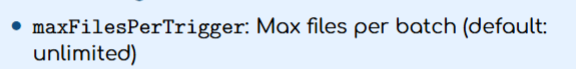

### Filter critical errors

In [6]:
critical_errors_df = parsed_logs_df.filter(
    (col("log_type") == "ERROR") & (col("message").contains("500"))
)

In [10]:
query = (
    critical_errors_df.writeStream.outputMode("append")
    .format("console") # sink en console
    .start()
)

query.awaitTermination(20)

-------------------------------------------
Batch: 0
-------------------------------------------
+-------------------+--------+--------------------+-------------+
|          timestamp|log_type|             message|       server|
+-------------------+--------+--------------------+-------------+
|2025-10-09 19:03:01|   ERROR|500 Internal Serv...|server-node-4|
|2025-10-09 19:03:01|   ERROR|500 Internal Serv...|server-node-2|
|2025-10-09 19:03:01|   ERROR|500 Internal Serv...|server-node-3|
|2025-10-09 19:03:01|   ERROR|500 Internal Serv...|server-node-2|
+-------------------+--------+--------------------+-------------+

-------------------------------------------
Batch: 1
-------------------------------------------
+-------------------+--------+--------------------+-------------+
|          timestamp|log_type|             message|       server|
+-------------------+--------+--------------------+-------------+
|2025-10-09 19:03:04|   ERROR|500 Internal Serv...|server-node-3|
|2025-10-09 1

False